In [ ]:
!pip install nibabel torch torchvision monai numpy matplotlib

#Preprocessing the dataframe and MRI images

In [ ]:
import os
import random
import numpy as np
import nibabel as nib
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve,
    f1_score, balanced_accuracy_score, roc_auc_score,
    recall_score, accuracy_score
)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

shared_drives_path = "/content/drive/Shared drives/"

if os.path.exists(shared_drives_path):
    drives = os.listdir(shared_drives_path)
    print("Available Shared Drives:")
    for drive_name in drives:
        print(f"  📁 {drive_name}")
else:
    print("No Shared Drives found. Make sure you've mounted your drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Available Shared Drives:
  📁 Fall2025BrainTumorDiagnosis


In [ ]:
base_path = "/content/drive/Shared drives/Fall2025BrainTumorDiagnosis/"
csv_path = "https://raw.githubusercontent.com/Erdos-Projects/fall-2025-brain-tumor-diagnosis/refs/heads/main/Clinical-data/UCSF-PDGM-metadata_v5.csv"

6 patients had follow-up images so we excluded those.

In [ ]:
# Read the CSV and remove follow-ups
df = pd.read_csv(csv_path)
df=df[~df["ID"].isin(["UCSF-PDGM-0433_FU007d", "UCSF-PDGM-0431_FU001d","UCSF-PDGM-0396_FU175d", "UCSF-PDGM-0429_FU003d", "UCSF-PDGM-0409_FU001d", "UCSF-PDGM-0391_FU016d"])]
print(len(df))

# Display basic info
print(f"CSV loaded successfully!")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

print("Column names:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i}. {col}")

print("\nFirst 5 rows:")
print(df.head())


495
CSV loaded successfully!
Shape: 495 rows × 16 columns

Column names:
  1. ID
  2. Sex
  3. Age at MRI
  4. WHO CNS Grade
  5. Final pathologic diagnosis (WHO 2021)
  6. MGMT status
  7. MGMT index
  8. 1p/19q
  9. IDH
  10. 1-dead 0-alive
  11. OS
  12. EOR
  13. Biopsy prior to imaging
  14. BraTS21 ID
  15. BraTS21 Segmentation Cohort
  16. BraTS21 MGMT Cohort

First 5 rows:
              ID Sex  Age at MRI  WHO CNS Grade  \
0  UCSF-PDGM-004   M          66              4   
1  UCSF-PDGM-005   F          80              4   
2  UCSF-PDGM-007   M          70              4   
3  UCSF-PDGM-008   M          70              4   
4  UCSF-PDGM-009   F          68              4   

  Final pathologic diagnosis (WHO 2021)    MGMT status MGMT index   1p/19q  \
0            Glioblastoma, IDH-wildtype       negative          0  unknown   
1            Glioblastoma, IDH-wildtype  indeterminate    unknown  unknown   
2            Glioblastoma, IDH-wildtype  indeterminate    unknown  unknown 

In [ ]:
print("📂 Contents of Shared Drive:")
for item in sorted(os.listdir(base_path)):
    full_path = os.path.join(base_path, item)
    if os.path.isfile(full_path):
        print(f"  📄 {item}")
    else:
        print(f"  📁 {item}/")

# Get all patient folders
patient_folders = sorted([f for f in os.listdir(base_path)
                         if os.path.isdir(os.path.join(base_path, f))])

print(f"Total patient folders: {len(patient_folders)}")
print(f"\nFirst 5 patients:")
for folder in patient_folders[:5]:
    print(f"  📁 {folder}")

# Check scans in the first patient
first_patient = patient_folders[0]
patient_path = os.path.join(base_path, first_patient)
scans = sorted(os.listdir(patient_path))

print(f"\n📂 Scans in {first_patient}:")
print(f"Total scans: {len(scans)}\n")
for i, scan in enumerate(scans, 1):
    print(f"{i}. {scan}")

# Check for label files in base directory
print("\n📄 Looking for label files in base directory:")
for item in os.listdir(base_path):
    if item.endswith(('.csv', '.txt', '.xlsx', '.json')):
        print(f"  Found: {item}")

📂 Contents of Shared Drive:
  📁 UCSF-PDGM-0004_nifti/
  📁 UCSF-PDGM-0005_nifti/
  📁 UCSF-PDGM-0007_nifti/
  📁 UCSF-PDGM-0008_nifti/
  📁 UCSF-PDGM-0009_nifti/
  📁 UCSF-PDGM-0010_nifti/
  📁 UCSF-PDGM-0011_nifti/
  📁 UCSF-PDGM-0012_nifti/
  📁 UCSF-PDGM-0013_nifti/
  📁 UCSF-PDGM-0014_nifti/
  📁 UCSF-PDGM-0015_nifti/
  📁 UCSF-PDGM-0016_nifti/
  📁 UCSF-PDGM-0017_nifti/
  📁 UCSF-PDGM-0018_nifti/
  📁 UCSF-PDGM-0019_nifti/
  📁 UCSF-PDGM-0020_nifti/
  📁 UCSF-PDGM-0021_nifti/
  📁 UCSF-PDGM-0022_nifti/
  📁 UCSF-PDGM-0023_nifti/
  📁 UCSF-PDGM-0024_nifti/
  📁 UCSF-PDGM-0025_nifti/
  📁 UCSF-PDGM-0026_nifti/
  📁 UCSF-PDGM-0027_nifti/
  📁 UCSF-PDGM-0029_nifti/
  📁 UCSF-PDGM-0030_nifti/
  📁 UCSF-PDGM-0031_nifti/
  📁 UCSF-PDGM-0032_nifti/
  📁 UCSF-PDGM-0033_nifti/
  📁 UCSF-PDGM-0034_nifti/
  📁 UCSF-PDGM-0035_nifti/
  📁 UCSF-PDGM-0036_nifti/
  📁 UCSF-PDGM-0037_nifti/
  📁 UCSF-PDGM-0038_nifti/
  📁 UCSF-PDGM-0039_nifti/
  📁 UCSF-PDGM-0040_nifti/
  📁 UCSF-PDGM-0041_nifti/
  📁 UCSF-PDGM-0042_nifti/
  📁 UCSF-P

In [ ]:
#set a random seed for later
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
# Get patient folders
patient_folders = sorted([f for f in os.listdir(base_path)
                         if os.path.isdir(os.path.join(base_path, f))])

# Extract patient number and pad to 4 digits
df['patient_num'] = df['ID'].str.extract(r'UCSF-PDGM-(\d+)')[0]
df['folder_name'] = 'UCSF-PDGM-' + df['patient_num'].str.zfill(4) + '_nifti'

# Filter to only patients we have imaging data for
df_with_imaging = df[df['folder_name'].isin(patient_folders)]

print(f"Total patients in CSV: {len(df)}")
print(f"Total folders: {len(patient_folders)}")
print(f"Matched patients (have both data and labels): {len(df_with_imaging)}")

# Check WHO Grade distribution
print(f"\n{'='*50}")
print(f"WHO Grade distribution:")
print(df_with_imaging['WHO CNS Grade'].value_counts().sort_index())
print(f"{'='*50}")

# Show first few matches
print(f"\nFirst 5 matched patients:")
print(df_with_imaging[['ID', 'folder_name', 'WHO CNS Grade']].head())

Total patients in CSV: 495
Total folders: 501
Matched patients (have both data and labels): 495

WHO Grade distribution:
WHO CNS Grade
2     56
3     43
4    396
Name: count, dtype: int64

First 5 matched patients:
              ID           folder_name  WHO CNS Grade
0  UCSF-PDGM-004  UCSF-PDGM-0004_nifti              4
1  UCSF-PDGM-005  UCSF-PDGM-0005_nifti              4
2  UCSF-PDGM-007  UCSF-PDGM-0007_nifti              4
3  UCSF-PDGM-008  UCSF-PDGM-0008_nifti              4
4  UCSF-PDGM-009  UCSF-PDGM-0009_nifti              4


##Sex vs Tumor grade

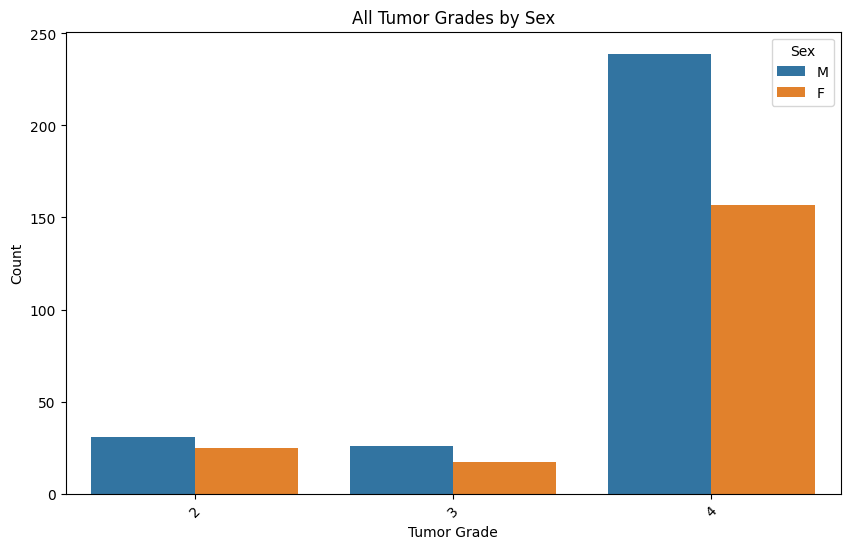

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

sns.countplot(
    data=df,
    x="WHO CNS Grade",
    hue="Sex"
)

plt.title("All Tumor Grades by Sex")
plt.xticks(rotation=45)
plt.xlabel("Tumor Grade")
plt.ylabel("Count")
plt.legend(title="Sex")
plt.show()

##IDH mutation status

All the IDH-mutated subtypes are encoded as mutated.

Among patients with IDH-wildtype gliomas, the average age is over 60 years, compared to roughly 36 years in those with IDH-mutant gliomas.

Most grade 4 patients in our dataset have IDH wildtype gliomas whereas lower grade (2/3) patients have mostly IDH mutated type. The heatmap seems to suggest that the IDH mutation is linked to tumor grade classification.

In [ ]:
df['IDH_encoded'] = df['IDH'].apply(lambda x: "wildtype" if str(x).lower() == "wildtype" else "mutated")
df["IDH_encoded"].value_counts()

,count
IDH_encoded,
wildtype,392
mutated,103


/tmp/ipython-input-3085839875.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WHO CNS Grade', y='Age at MRI', data=df, palette='Set2')


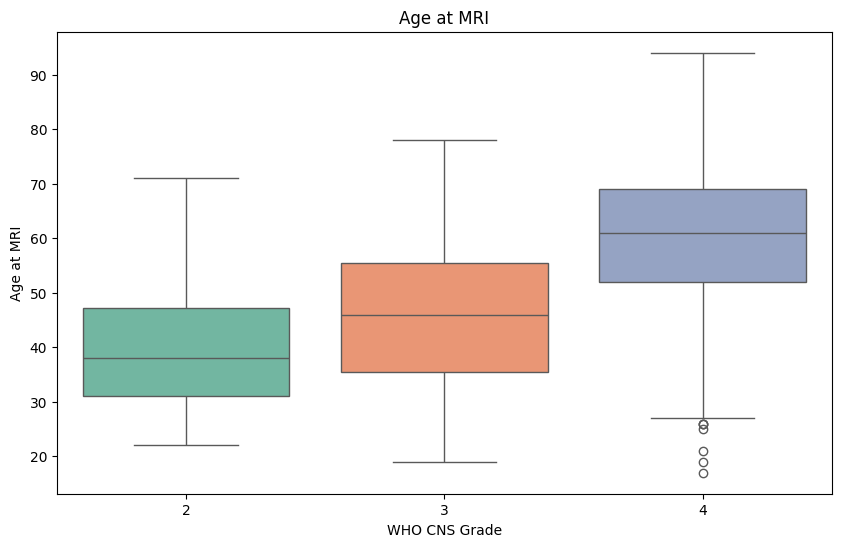

/tmp/ipython-input-3085839875.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='IDH_encoded', y='Age at MRI', data=df, palette='Set2')


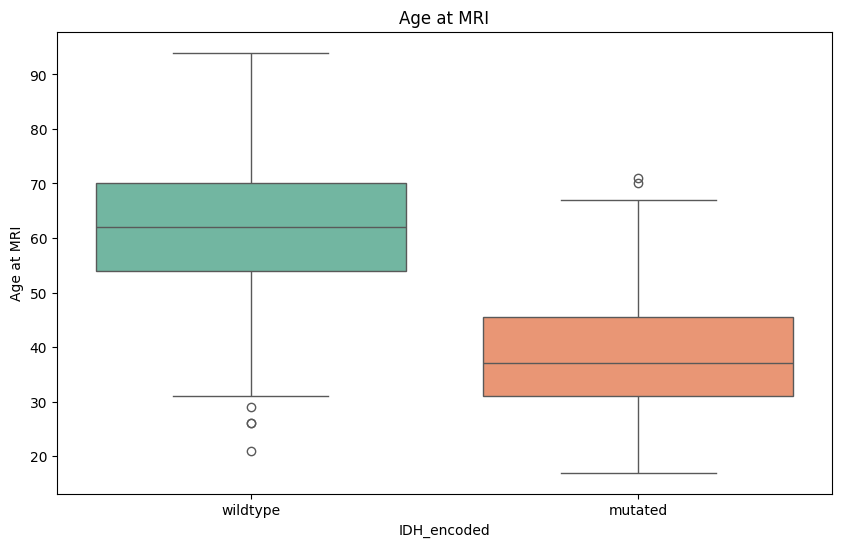

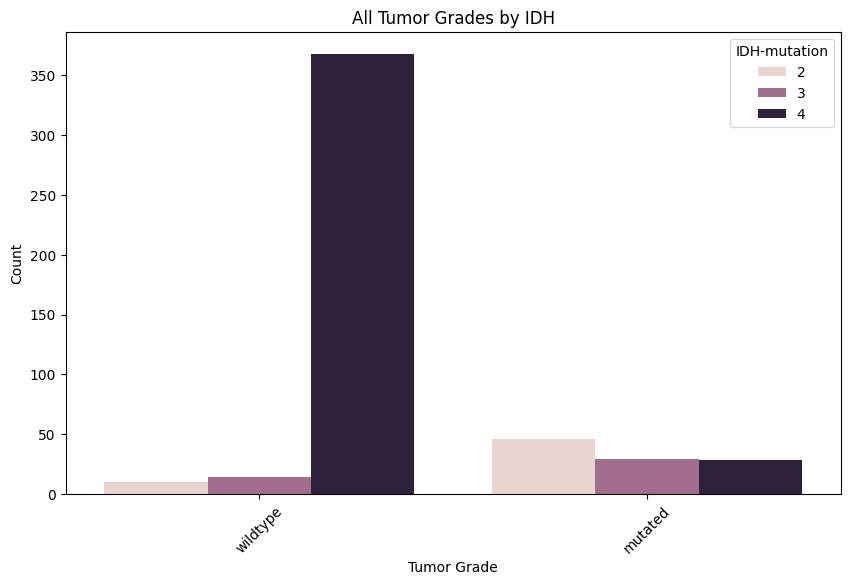

In [ ]:
plt.figure(figsize=(10,6))

sns.boxplot(x='WHO CNS Grade', y='Age at MRI', data=df, palette='Set2')
plt.title('Age at MRI')
plt.show()

plt.figure(figsize=(10,6))

sns.boxplot(x='IDH_encoded', y='Age at MRI', data=df, palette='Set2')
plt.title('Age at MRI')
plt.show()

plt.figure(figsize=(10,6))

sns.countplot(
    data=df,
    hue="WHO CNS Grade",
    x="IDH_encoded"
)

plt.title("All Tumor Grades by IDH")
plt.xticks(rotation=45)
plt.xlabel("Tumor Grade")
plt.ylabel("Count")
plt.legend(title="IDH-mutation")
plt.show()

Text(0.5, 1.0, 'Proportion of IDH Mutation Types per Tumor Grade')

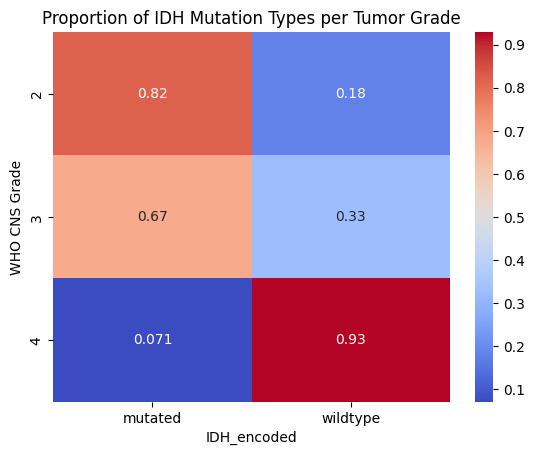

In [ ]:
ct = pd.crosstab(df['WHO CNS Grade'], df['IDH_encoded'], normalize='index')
sns.heatmap(ct, annot=True, cmap='coolwarm')
plt.title('Proportion of IDH Mutation Types per Tumor Grade')

##1p/19q codeletion status
Next we encode 1p/19q codeletion. 1p refers to the short arm of chromosome 1 while 19q refers to the long arm of chromosome 19. If both are missing from a patient's tumor DNA, we say that the patient has 1p/19q codeletion.

All of the unknown 1p/19q status are in grade 4 (this could be due to the fact that other molecular tests were enough to conclude that these gliomas were in grade 4 and so this particular test was skipped). To make sure our model recognizes this pattern, we will keep the unknown.

On the other hand, relative codeletion (meaning one missing, one intact) are equally spread among the three grades. We encode them as "intact" and this aligns with the clinical assumption.

Unfortunately, there are only nine 1p/19q codeletion in our data set and they are all in grade 2, so this will potentially prove harder for any prediction model to perform well for lower grade (2,3).


In [ ]:
print(df["1p/19q"].value_counts())

print(df.groupby("WHO CNS Grade")['1p/19q'].value_counts())

1p/19q
intact                  389
unknown                  91
co-deletion               9
relative co-deletion      6
Name: count, dtype: int64
WHO CNS Grade  1p/19q              
2              intact                   45
               co-deletion               9
               relative co-deletion      2
3              intact                   41
               relative co-deletion      2
4              intact                  303
               unknown                  91
               relative co-deletion      2
Name: count, dtype: int64


Text(0.5, 1.0, 'Proportion of 1p/19q status per Tumor Grade')

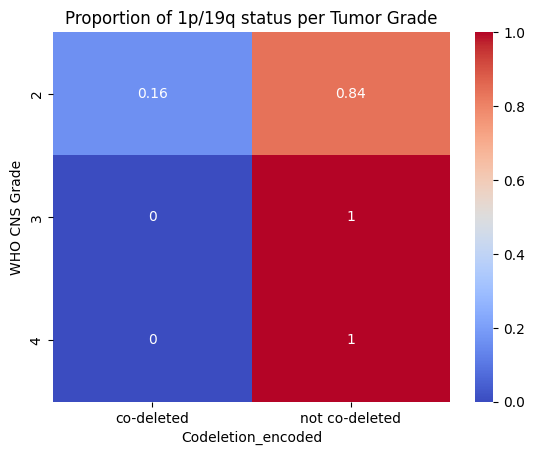

In [ ]:
df['Codeletion_encoded'] = df['1p/19q'].apply(lambda x: "co-deleted" if str(x).lower() == "co-deletion" else "not co-deleted")
df['Codeletion_unknown'] = df['1p/19q'].apply(lambda x: 1 if str(x).lower() == "unknown" else 0)

ct = pd.crosstab(df['WHO CNS Grade'], df['Codeletion_encoded'], normalize='index')
sns.heatmap(ct, annot=True, cmap='coolwarm')
plt.title('Proportion of 1p/19q status per Tumor Grade')

##IDH mutation vs 1p/19q codeletion status

Text(0.5, 1.0, 'Proportion of 1p/19q status per IDH mutation status')

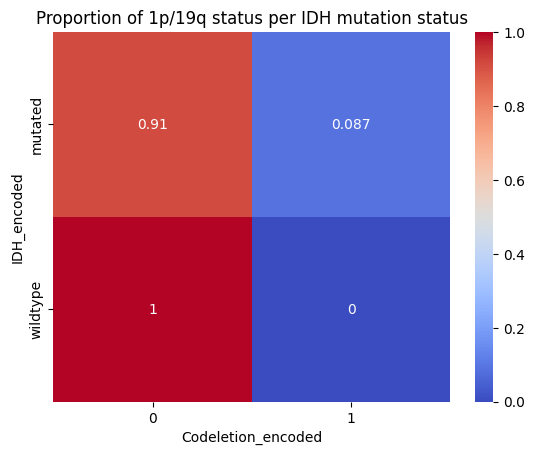

In [ ]:
ct = pd.crosstab(df['IDH_encoded'], df['Codeletion_encoded'], normalize='index')
sns.heatmap(ct, annot=True, cmap='coolwarm')
plt.title('Proportion of 1p/19q status per IDH mutation status')

#Gliblastoma vs Others
We focus on binary classification of glioblastoma (GBM, WHO CNS Grade 4) versus other diffuse gliomas (Grade 2–3) because this distinction has significant clinical and biological importance. Glioblastoma is an aggressive, high-grade tumor associated with markedly worse prognosis, rapid progression, and distinct therapeutic strategies compared to lower-grade gliomas. In routine clinical practice, timely and accurate identification of glioblastoma affects treatment planning, eligibility for clinical trials, patient counseling, and surgical decision-making.

Although multi-class glioma grading is ideal, reliable differentiation between Grade 2 and Grade 3 gliomas remains challenging even among experts, and data imbalance in public MRI datasets makes robust 3-class training unstable. In contrast, distinguishing GBM from lower-grade gliomas is both clinically essential and empirically more stable, making it a natural first step toward a full multi-grade diagnostic model.

In [ ]:
# =============================================
# 1. LOAD LABELS AND METADATA
# =============================================
def load_labels(csv_path, base_path):
    df = pd.read_csv(csv_path)

    # Remove follow-ups only
    df = df[~df['ID'].str.contains('_FU', na=False)].copy()

    # Match only existing patient folders
    patient_folders = sorted([
        f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))
    ])

    # Extract numeric patient ID and construct folder names
    df['patient_num'] = df['ID'].str.extract(r'UCSF-PDGM-(\d+)')[0]
    df['folder_name'] = 'UCSF-PDGM-' + df['patient_num'].str.zfill(4) + '_nifti'
    df_matched = df[df['folder_name'].isin(patient_folders)].copy()

    # Binary classification - Grade 4 (Glioblastoma) vs Others (Grade 2+3)
    # Map WHO grades to classes: Grade 2,3 → 0 (Other), Grade 4 → 1 (Glioblastoma)
    grade_to_class = {2: 0, 3: 0, 4: 1}  # Binary: 0=Lower-grade, 1=Glioblastoma
    df_matched['class_label'] = df_matched['WHO CNS Grade'].map(grade_to_class)

    # Encode metadata
    df_matched['Sex_encoded'] = df_matched['Sex'].apply(lambda x: 1 if str(x).upper() == "M" else 0)
    df_matched['IDH_encoded'] = df_matched['IDH'].apply(lambda x: 0 if str(x).lower() == "wildtype" else 1)
    df_matched['Codeletion_encoded'] = df_matched['1p/19q'].apply(lambda x: 1 if str(x).lower() == "co-deletion" else 0)
    df_matched['Codeletion_unknown'] = df_matched['1p/19q'].apply(lambda x: 1 if str(x).lower() == "unknown" else 0)

    # Scale age
    #df_matched['Age_scaled'] = StandardScaler().fit_transform(
        #df_matched[['Age at MRI']].fillna(df_matched['Age at MRI'].mean())
    #)
    # Create and save the scaler
    age_scaler = StandardScaler()
    age_filled = df_matched[['Age at MRI']].fillna(df_matched['Age at MRI'].mean())
    df_matched['Age_scaled'] = age_scaler.fit_transform(age_filled)

    # Build label and metadata dictionaries
    labels_dict = dict(zip(df_matched['folder_name'], df_matched['class_label']))
    metadata_df = df_matched.set_index('folder_name')[
        ['Age_scaled', 'Sex_encoded', 'IDH_encoded', 'Codeletion_encoded', 'Codeletion_unknown']
    ]
    metadata_dict = metadata_df.to_dict(orient='index')

    # --- Print summaries ---
    print(f"✅ Loaded {len(labels_dict)} patients with labels")
    print("\nBinary Classification: Glioblastoma (Grade 4) vs Other Gliomas (Grade 2+3)")
    print("Original WHO CNS Grade distribution:")
    print(df_matched['WHO CNS Grade'].value_counts().sort_index())
    print("\nBinary class distribution:")
    class_names = {0: 'Other Gliomas (Grade 2+3)', 1: 'Glioblastoma (Grade 4)'}
    for cls, name in class_names.items():
        count = (df_matched['class_label'] == cls).sum()
        print(f"  Class {cls} ({name}): {count} patients")
    print("\n1p/19q category counts:")
    print(df_matched['1p/19q'].value_counts(dropna=False))

    return labels_dict, metadata_dict, patient_folders

# =============================================
# 2. DATASET CLASS (returns multi-slice per modality)
# =============================================
class MRIDataset(Dataset):
    def __init__(self, base_path, patient_list, labels_dict, metadata_dict,
                 modalities=None, augment=False, n_slices=3,
                 extra_slices_by_class=None):
        self.base_path = base_path
        self.labels_dict = labels_dict
        self.metadata_dict = metadata_dict
        self.modalities = modalities if modalities else ['ADC', 'FLAIR', 'T1', 'T1c', 'T2']
        self.augment = augment
        self.n_slices = n_slices
        self.half_w = n_slices // 2
        # Binary class expansion (0=Other, 1=Glioblastoma)
        self.extra_slices_by_class = extra_slices_by_class or {
            0: [-2, -1, 0, 1, 2],  # Other gliomas (Grade 2+3)
            1: [0]   # Glioblastoma (Grade 4)
        }

        # Build balanced sample list
        self.samples = []
        for folder in patient_list:
            pid = folder.replace('_nifti','')
            label = labels_dict[folder]
            patient_path = os.path.join(base_path, folder)
            try:
                seg_path = os.path.join(patient_path, f"{pid}_tumor_segmentation.nii.gz")
                seg = nib.load(seg_path).get_fdata()
                seg_bin = (seg > 0).astype(np.uint8)
                area = seg_bin.sum(axis=(0,1))
                z_center = int(np.argmax(area)) if area.max() > 0 else seg.shape[2]//2
                z_max = seg.shape[2]
            except Exception:
                z_center, z_max = 120, 240

            rel_offsets = self.extra_slices_by_class.get(label, [0])
            abs_slices = [z_center + r for r in rel_offsets if 0 <= z_center + r < z_max]
            for z in abs_slices:
                self.samples.append((folder, label, z))

        print("📊 Dataset built with slice expansion (multi-slice mode):")
        counts = [sum(1 for _, l, _ in self.samples if l == c) for c in [0, 1]]
        print(f"  Other Gliomas: {counts[0]} | Glioblastoma: {counts[1]} | Total: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def _safe_load_slice(self, img, slice_idx):
        slice_idx = np.clip(slice_idx, 0, img.shape[2]-1)
        img2d = img[:, :, slice_idx].astype(np.float32)
        mi, ma = np.nanmin(img2d), np.nanmax(img2d)
        return (img2d - mi) / (ma - mi) if ma > mi else np.zeros_like(img2d)

    def __getitem__(self, idx):
        folder, label, z_center = self.samples[idx]
        pid = folder.replace('_nifti','')
        patient_path = os.path.join(self.base_path, folder)

        # Multi-slice window
        slice_indices = [z_center + o for o in range(-self.half_w, self.half_w + 1)]

        # Load modalities
        channels = []
        for mod in self.modalities:
            try:
                img = nib.load(os.path.join(patient_path, f"{pid}_{mod}.nii.gz")).get_fdata()
            except Exception:
                img = np.zeros((240, 240, max(slice_indices)+1), dtype=np.float32)
            for s in slice_indices:
                channels.append(self._safe_load_slice(img, s))

        img_tensor = torch.tensor(np.stack(channels, axis=0), dtype=torch.float32)

        # Metadata
        meta_vals = [
            self.metadata_dict[folder]['Age_scaled'],
            self.metadata_dict[folder]['Sex_encoded'],
            self.metadata_dict[folder]['IDH_encoded'],
            self.metadata_dict[folder]['Codeletion_encoded'],
            self.metadata_dict[folder]['Codeletion_unknown']
        ]
        meta_tensor = torch.tensor(meta_vals, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)

        # Augmentation for minority class (Other Gliomas)
        if self.augment and label == 0:  # Other Gliomas
            # Geometric augmentations
            if np.random.rand() > 0.5:
                img_tensor = img_tensor.flip(-1)
            if np.random.rand() > 0.5:
                img_tensor = img_tensor.flip(-2)
            k = np.random.choice([0,1,2,3])
            if k:
                img_tensor = torch.rot90(img_tensor, k, dims=[1,2])

            # Intensity augmentations
            if np.random.rand() > 0.6:
                brightness = 0.85 + np.random.rand() * 0.3  # 0.85-1.15
                img_tensor = img_tensor * brightness
                img_tensor = torch.clamp(img_tensor, 0, 1)

            if np.random.rand() > 0.7:
                noise = torch.randn_like(img_tensor) * 0.03
                img_tensor = img_tensor + noise
                img_tensor = torch.clamp(img_tensor, 0, 1)

        return img_tensor, meta_tensor, label_tensor


# =============================================
# 3. CNN + METADATA MODEL (SIMPLIFIED - NO SEGMENTATION HEAD)
# =============================================
class CNN2D_Meta(nn.Module):
    def __init__(self, n_channels=15, n_meta=5, n_classes=2):
        super().__init__()

        # --- Encoder (same as before) ---
        self.conv_layers = nn.Sequential(
            nn.Conv2d(n_channels, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),  # 240→120
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),          # 120→60
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),           # 60→30
            nn.Conv2d(128,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2)           # 30→15
        )

        # --- Classification head ---
        self.flatten_dim = 256*15*15
        self.fc_img  = nn.Sequential(nn.Linear(self.flatten_dim,512), nn.ReLU(), nn.Dropout(0.5))
        self.fc_meta = nn.Sequential(nn.Linear(n_meta,32), nn.ReLU(), nn.Dropout(0.2))
        self.fc_combined = nn.Sequential(
            nn.Linear(512+32,128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128,n_classes)
        )

    def forward(self, x_img, x_meta):
        # Extract features
        feats = self.conv_layers(x_img)           # [B,256,15,15]

        # Classification path
        x_flat = torch.flatten(feats, 1)
        x_img_feat = self.fc_img(x_flat)
        x_meta_feat = self.fc_meta(x_meta)
        logits = self.fc_combined(torch.cat((x_img_feat, x_meta_feat), dim=1))

        return logits


# =============================================
# 4. TRAINING FUNCTION (SIMPLIFIED - NO SEGMENTATION)
# =============================================
def train_model(model, train_loader, val_loader,
                criterion, optimizer, scheduler,
                device='cuda', epochs=20):

    n_classes = 2  # Binary classification
    class_names = ['Other Gliomas', 'Glioblastoma']
    model.to(device)

    # Use CrossEntropyLoss without reduction for per-sample loss calculation
    criterion_no_reduce = nn.CrossEntropyLoss(reduction='none')

    for epoch in range(epochs):
        # ---------- TRAIN ----------
        model.train()
        running_loss, correct, total = 0, 0, 0
        class_correct = np.zeros(n_classes)
        class_total = np.zeros(n_classes)
        class_loss = np.zeros(n_classes)

        for imgs, metas, labels in train_loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(imgs, metas)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            bs = labels.size(0)
            running_loss += loss.item() * bs
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += bs

            # Calculate per-class metrics
            with torch.no_grad():
                per_sample_loss = criterion_no_reduce(logits, labels)
                for c in range(n_classes):
                    idx = labels == c
                    class_total[c] += idx.sum().item()
                    class_correct[c] += (preds[idx] == labels[idx]).sum().item()
                    if idx.sum() > 0:
                        class_loss[c] += per_sample_loss[idx].sum().item()

        train_loss = running_loss / total
        train_acc = 100 * correct / total
        train_acc_pc = 100 * class_correct / np.maximum(class_total, 1)
        train_loss_pc = class_loss / np.maximum(class_total, 1)

        # ---------- VALIDATION ----------
        model.eval()
        running_loss, correct, total = 0, 0, 0
        class_correct[:] = 0
        class_total[:] = 0
        class_loss[:] = 0

        with torch.no_grad():
            for imgs, metas, labels in val_loader:
                imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)

                logits = model(imgs, metas)
                loss = criterion(logits, labels)

                bs = labels.size(0)
                running_loss += loss.item() * bs
                preds = logits.argmax(1)
                correct += (preds == labels).sum().item()
                total += bs

                # Calculate per-class metrics
                per_sample_loss = criterion_no_reduce(logits, labels)
                for c in range(n_classes):
                    idx = labels == c
                    class_total[c] += idx.sum().item()
                    class_correct[c] += (preds[idx] == labels[idx]).sum().item()
                    if idx.sum() > 0:
                        class_loss[c] += per_sample_loss[idx].sum().item()

        val_loss = running_loss / max(total, 1)
        val_acc = 100 * correct / max(total, 1)
        val_acc_pc = 100 * class_correct / np.maximum(class_total, 1)
        val_loss_pc = class_loss / np.maximum(class_total, 1)

        # Print results
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss {train_loss:.4f}, Acc {train_acc:.2f}% | "
              f"Val Loss {val_loss:.4f}, Acc {val_acc:.2f}%")

        for c in range(n_classes):
            print(f"  {class_names[c]}: Train Acc {train_acc_pc[c]:.2f}%, Loss {train_loss_pc[c]:.4f} | "
                  f"Val Acc {val_acc_pc[c]:.2f}%, Loss {val_loss_pc[c]:.4f}")

        scheduler.step(val_loss)

    return model


# =====================================================
# 5 COMPREHENSIVE MODEL EVALUATION FUNCTION
# =====================================================
def evaluate_model_comprehensive(model, data_loader, device, class_names, dataset_name="Test"):
    """
    Comprehensive evaluation with detailed statistics and visualizations
    """
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for imgs, metas, labels in data_loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)

            logits = model(imgs, metas)
            probs = torch.softmax(logits, dim=1)
            preds = logits.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # =====================================================
    # 5.1. BASIC METRICS
    # =====================================================
    print("=" * 80)
    print(f"{dataset_name} SET EVALUATION RESULTS")
    print("=" * 80)

    # Overall accuracy
    accuracy = 100 * (all_preds == all_labels).sum() / len(all_labels)
    balanced_acc = 100 * balanced_accuracy_score(all_labels, all_preds)

    print(f"\n📊 OVERALL METRICS:")
    print(f"  Total Samples: {len(all_labels)}")
    print(f"  Overall Accuracy: {accuracy:.2f}%")
    print(f"  Balanced Accuracy: {balanced_acc:.2f}%")

    # Per-class metrics
    print(f"\n📈 PER-CLASS PERFORMANCE:")
    for i, class_name in enumerate(class_names):
        class_mask = all_labels == i
        class_acc = 100 * (all_preds[class_mask] == all_labels[class_mask]).sum() / class_mask.sum()
        class_count = class_mask.sum()

        # Calculate precision, recall, F1
        true_positives = ((all_preds == i) & (all_labels == i)).sum()
        false_positives = ((all_preds == i) & (all_labels != i)).sum()
        false_negatives = ((all_preds != i) & (all_labels == i)).sum()

        precision = 100 * true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = 100 * true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        print(f"\n  {class_name} (Class {i}):")
        print(f"    Samples: {class_count}")
        print(f"    Accuracy: {class_acc:.2f}%")
        print(f"    Precision: {precision:.2f}%")
        print(f"    Recall (Sensitivity): {recall:.2f}%")
        print(f"    F1-Score: {f1:.2f}%")

    # =====================================================
    # 5.2. CONFUSION MATRIX
    # =====================================================
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n📋 CONFUSION MATRIX:")
    print(f"{'':20s} {'Predicted ' + class_names[0]:>25s} {'Predicted ' + class_names[1]:>25s}")
    for i, class_name in enumerate(class_names):
        print(f"  Actual {class_name:15s} {cm[i,0]:15d} {cm[i,1]:15d}")

    # =====================================================
    # 5.3. CLASSIFICATION REPORT
    # =====================================================
    print(f"\n📝 DETAILED CLASSIFICATION REPORT:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=3))

    # =====================================================
    # 5.4. CREATE VISUALIZATIONS
    # =====================================================
    fig = plt.figure(figsize=(20, 12))

    # --- Plot 1: Confusion Matrix (Normalized) ---
    ax1 = plt.subplot(2, 3, 1)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Percentage'})
    plt.title(f'Normalized Confusion Matrix\n{dataset_name} Set', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)

    # --- Plot 2: Confusion Matrix (Counts) ---
    ax2 = plt.subplot(2, 3, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix (Counts)\n{dataset_name} Set', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)

    # --- Plot 3: Per-Class Metrics Bar Chart ---
    ax3 = plt.subplot(2, 3, 3)
    metrics_data = []
    for i in range(len(class_names)):
        class_mask = all_labels == i
        class_acc = 100 * (all_preds[class_mask] == all_labels[class_mask]).sum() / class_mask.sum()

        tp = ((all_preds == i) & (all_labels == i)).sum()
        fp = ((all_preds == i) & (all_labels != i)).sum()
        fn = ((all_preds != i) & (all_labels == i)).sum()

        prec = 100 * tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = 100 * tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0

        metrics_data.append([class_acc, prec, rec, f1])

    metrics_data = np.array(metrics_data)
    x = np.arange(len(class_names))
    width = 0.2

    plt.bar(x - 1.5*width, metrics_data[:, 0], width, label='Accuracy', color='steelblue')
    plt.bar(x - 0.5*width, metrics_data[:, 1], width, label='Precision', color='orange')
    plt.bar(x + 0.5*width, metrics_data[:, 2], width, label='Recall', color='green')
    plt.bar(x + 1.5*width, metrics_data[:, 3], width, label='F1-Score', color='red')

    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Score (%)', fontsize=12)
    plt.title(f'Per-Class Performance Metrics\n{dataset_name} Set', fontsize=14, fontweight='bold')
    plt.xticks(x, class_names, rotation=15, ha='right')
    plt.legend()
    plt.ylim(0, 105)
    plt.grid(axis='y', alpha=0.3)

    # --- Plot 4: ROC Curve ---
    ax4 = plt.subplot(2, 3, 4)
    for i, class_name in enumerate(class_names):
        # One-vs-rest approach
        y_true_binary = (all_labels == i).astype(int)
        y_score = all_probs[:, i]

        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, linewidth=2,
                label=f'{class_name} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves\n{dataset_name} Set', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)

    # --- Plot 5: Precision-Recall Curve ---
    ax5 = plt.subplot(2, 3, 5)
    for i, class_name in enumerate(class_names):
        y_true_binary = (all_labels == i).astype(int)
        y_score = all_probs[:, i]

        precision, recall, _ = precision_recall_curve(y_true_binary, y_score)
        avg_precision = np.mean(precision)

        plt.plot(recall, precision, linewidth=2,
                label=f'{class_name} (AP = {avg_precision:.3f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Precision-Recall Curves\n{dataset_name} Set', fontsize=14, fontweight='bold')
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)

    # --- Plot 6: Prediction Confidence Distribution ---
    ax6 = plt.subplot(2, 3, 6)
    for i, class_name in enumerate(class_names):
        class_mask = all_labels == i
        confidences = all_probs[class_mask, i]  # Confidence for true class
        plt.hist(confidences, bins=20, alpha=0.6, label=f'{class_name}', edgecolor='black')

    plt.xlabel('Prediction Confidence', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title(f'Confidence Distribution\n(True Class Probabilities)', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{dataset_name.lower()}_evaluation_results.png', dpi=300, bbox_inches='tight')
    print(f"\n💾 Visualization saved as '{dataset_name.lower()}_evaluation_results.png'")
    plt.show()

    # =====================================================
    # 5.5. MISCLASSIFICATION ANALYSIS
    # =====================================================
    print(f"\n❌ MISCLASSIFICATION ANALYSIS:")
    misclassified_mask = all_preds != all_labels
    n_misclassified = misclassified_mask.sum()

    print(f"  Total misclassifications: {n_misclassified} / {len(all_labels)} ({100*n_misclassified/len(all_labels):.2f}%)")

    if n_misclassified > 0:
        print(f"\n  Misclassification breakdown:")
        for true_class in range(len(class_names)):
            for pred_class in range(len(class_names)):
                if true_class != pred_class:
                    count = ((all_labels == true_class) & (all_preds == pred_class)).sum()
                    if count > 0:
                        pct = 100 * count / (all_labels == true_class).sum()
                        avg_conf = all_probs[(all_labels == true_class) & (all_preds == pred_class), pred_class].mean()
                        print(f"    {class_names[true_class]} → {class_names[pred_class]}: "
                              f"{count} cases ({pct:.1f}%), avg confidence: {avg_conf:.3f}")

    print("\n" + "=" * 80)

    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }


# =====================================================
# 6. MAIN EXECUTION
# =====================================================
if __name__ == "__main__":
    # Set paths (update these to your actual paths)

    # Load labels and metadata
    labels_dict, metadata_dict, patient_folders = load_labels(csv_path, base_path)

    # --- Prepare splits ---
    patients = list(labels_dict.keys())
    labels = np.array([labels_dict[p] for p in patients])

    trainval_patients, test_patients = train_test_split(
        patients, test_size=0.2, random_state=42, stratify=labels
    )
    y_trainval = np.array([labels_dict[p] for p in trainval_patients])
    train_patients, val_patients = train_test_split(
        trainval_patients, test_size=0.25, random_state=42, stratify=y_trainval
    )
    print(f"\n📊 Data splits: Train {len(train_patients)}, Val {len(val_patients)}, Test {len(test_patients)}")

    # --- Define MRI modalities and number of slices ---
    modalities = ['ADC', 'FLAIR', 'T1', 'T1c', 'T2']
    n_slices = 1
    n_channels = len(modalities) * n_slices
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}\n")

    # --- Slice expansion (binary classification) ---
    train_extra = {0: [-2, -1, 0, 1, 2], 1: [0]}  # More slices for minority (Other Gliomas)
    eval_extra = {0: [0], 1: [0]}   # Same for validation/test

    # --- Create datasets ---
    train_dataset = MRIDataset(base_path, train_patients, labels_dict, metadata_dict,
                               modalities=modalities, augment=True, n_slices=n_slices,
                               extra_slices_by_class=train_extra)
    val_dataset = MRIDataset(base_path, val_patients, labels_dict, metadata_dict,
                             modalities=modalities, augment=False, n_slices=n_slices,
                             extra_slices_by_class=eval_extra)
    test_dataset = MRIDataset(base_path, test_patients, labels_dict, metadata_dict,
                              modalities=modalities, augment=False, n_slices=n_slices,
                              extra_slices_by_class=eval_extra)

    # --- Weighted sampler for balanced batches during training ---
    all_labels_train = [lbl for (_, lbl, _) in train_dataset.samples]
    class_sample_count = np.array([all_labels_train.count(c) for c in [0, 1]])

    # Inverse frequency weighting (more common class gets lower weight)
    weights = 1.0 / class_sample_count
    samples_weight = np.array([weights[lbl] for lbl in all_labels_train], dtype=np.float32)
    sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

    # --- Data loaders (no sampler needed, training data is balanced) ---
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

    print(f"✅ Loaders ready: Train: {len(train_loader)} batches | "
          f"Val: {len(val_loader)} | Test: {len(test_loader)}\n")

    # =====================================================
    # 6.1. TRAIN CNN (Binary Classification)
    # =====================================================
    model = CNN2D_Meta(n_channels=n_channels, n_meta=5, n_classes=2).to(device)

    # Class weights (adjust based on your preference)
    class_weights = torch.FloatTensor([3, 1.0]).to(device)  # [Other Gliomas, Glioblastoma]
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    print("=" * 70)
    print("TRAINING: Glioblastoma vs Other Gliomas (Binary Classification)")
    print("=" * 70)

    trained_model = train_model(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler,
        device=device, epochs=20
    )

    print("\n✅ Training complete!")
    # ✅ Save to Google Drive so you don't lose it
    save_path = "/content/drive/MyDrive/brain_mri_models/glioblastoma_classifier.pth"
    torch.save(trained_model.state_dict(), save_path)
    print(f"✅ Model saved to Drive: {save_path}")


    # =====================================================
    # 6.2. ANALYZE IDH DISTRIBUTION BY CLASS
    # =====================================================
    print("\n" + "="*70)
    print("IDH STATUS ANALYSIS BY CLASS")
    print("="*70)

    # Organize patients by class
    patients_by_class = {0: [], 1: []}
    for patient in patients:
        cls = labels_dict[patient]
        patients_by_class[cls].append(patient)

    class_names = {0: 'Other Gliomas (Grade 2+3)', 1: 'Glioblastoma (Grade 4)'}

    print("\nIDH distribution by predicted class:")
    for cls in [0, 1]:
        patients_in_class = patients_by_class[cls]
        idh_wt = sum(1 for p in patients_in_class if metadata_dict[p]['IDH_encoded'] == 0)
        idh_mut = sum(1 for p in patients_in_class if metadata_dict[p]['IDH_encoded'] == 1)
        total = len(patients_in_class)

        print(f"\n{class_names[cls]}:")
        print(f"  Total patients: {total}")
        print(f"  IDH-wildtype: {idh_wt} ({100*idh_wt/total:.1f}%)")
        print(f"  IDH-mutant: {idh_mut} ({100*idh_mut/total:.1f}%)")

        # Also show 1p/19q status for context
        codeletion = sum(1 for p in patients_in_class if metadata_dict[p]['Codeletion_encoded'] == 1)
        intact = sum(1 for p in patients_in_class if metadata_dict[p]['Codeletion_encoded'] == 0
                     and metadata_dict[p]['Codeletion_unknown'] == 0)
        unknown = sum(1 for p in patients_in_class if metadata_dict[p]['Codeletion_unknown'] == 1)

        print(f"  1p/19q co-deletion: {codeletion} ({100*codeletion/total:.1f}%)")
        print(f"  1p/19q intact: {intact} ({100*intact/total:.1f}%)")
        print(f"  1p/19q unknown: {unknown} ({100*unknown/total:.1f}%)")

    print("\n" + "="*70)
    print("INTERPRETATION:")
    print("="*70)
    print("If Glioblastoma class shows high IDH-wildtype percentage (>90%),")
    print("this confirms most Grade 4 tumors are PRIMARY glioblastomas")
    print("(not secondary progression from lower grades).")
    print("="*70)

    # Save the trained model
    torch.save(trained_model.state_dict(), 'glioblastoma_classifier.pth')
    print("\nModel saved to 'glioblastoma_classifier.pth'")

✅ Loaded 495 patients with labels

Binary Classification: Glioblastoma (Grade 4) vs Other Gliomas (Grade 2+3)
Original WHO CNS Grade distribution:
WHO CNS Grade
2     56
3     43
4    396
Name: count, dtype: int64

Binary class distribution:
  Class 0 (Other Gliomas (Grade 2+3)): 99 patients
  Class 1 (Glioblastoma (Grade 4)): 396 patients

1p/19q category counts:
1p/19q
intact                  389
unknown                  91
co-deletion               9
relative co-deletion      6
Name: count, dtype: int64

📊 Data splits: Train 297, Val 99, Test 99
Using device: cpu

📊 Dataset built with slice expansion (multi-slice mode):
  Other Gliomas: 295 | Glioblastoma: 238 | Total: 533
📊 Dataset built with slice expansion (multi-slice mode):
  Other Gliomas: 20 | Glioblastoma: 79 | Total: 99
📊 Dataset built with slice expansion (multi-slice mode):
  Other Gliomas: 20 | Glioblastoma: 79 | Total: 99
✅ Loaders ready: Train: 67 batches | Val: 13 | Test: 13

TRAINING: Glioblastoma vs Other Gliomas (B

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

torch.save(trained_model.state_dict(), "best_epoch_final.pth")
print("✅ Model saved as best_epoch_final.pth")

save_path = "/content/drive/MyDrive/brain_mri_models/best_epoch_final.pth"
torch.save(trained_model.state_dict(), save_path)
print(f"✅ Model saved to {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved as best_epoch_final.pth
✅ Model saved to /content/drive/MyDrive/brain_mri_models/best_epoch_final.pth



FINAL EVALUATION ON TEST SET
Test SET EVALUATION RESULTS

📊 OVERALL METRICS:
  Total Samples: 99
  Overall Accuracy: 88.89%
  Balanced Accuracy: 81.84%

📈 PER-CLASS PERFORMANCE:

  Other Gliomas (Class 0):
    Samples: 20
    Accuracy: 70.00%
    Precision: 73.68%
    Recall (Sensitivity): 70.00%
    F1-Score: 71.79%

  Glioblastoma (Class 1):
    Samples: 79
    Accuracy: 93.67%
    Precision: 92.50%
    Recall (Sensitivity): 93.67%
    F1-Score: 93.08%

📋 CONFUSION MATRIX:
                       Predicted Other Gliomas    Predicted Glioblastoma
  Actual Other Gliomas                14               6
  Actual Glioblastoma                  5              74

📝 DETAILED CLASSIFICATION REPORT:
               precision    recall  f1-score   support

Other Gliomas      0.737     0.700     0.718        20
 Glioblastoma      0.925     0.937     0.931        79

     accuracy                          0.889        99
    macro avg      0.831     0.818     0.824        99
 weighted avg      0

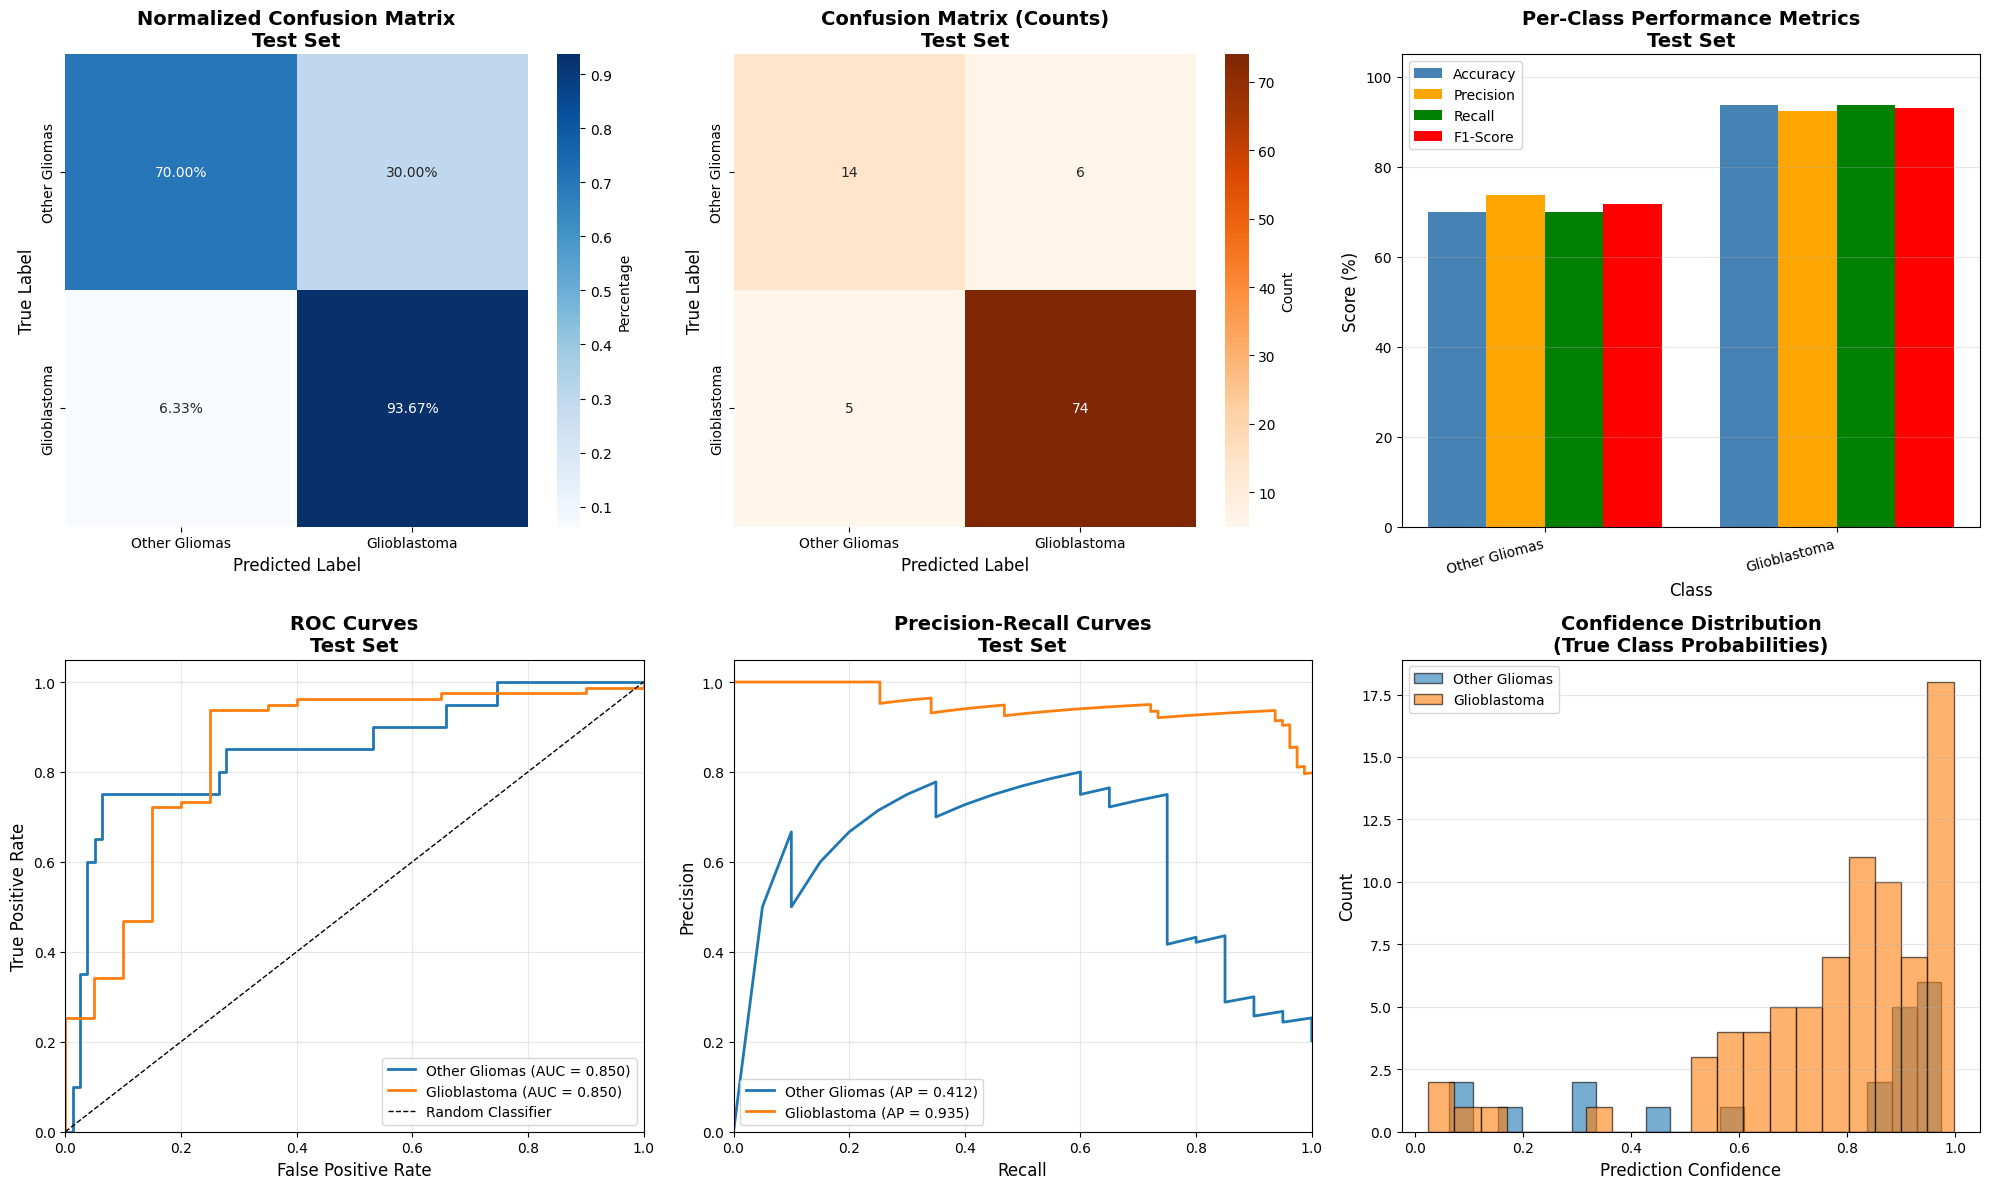


❌ MISCLASSIFICATION ANALYSIS:
  Total misclassifications: 11 / 99 (11.11%)

  Misclassification breakdown:
    Other Gliomas → Glioblastoma: 6 cases (30.0%), avg confidence: 0.769
    Glioblastoma → Other Gliomas: 5 cases (6.3%), avg confidence: 0.878


✅ Evaluation complete!

🔥 FINAL TEST METRICS:
Accuracy:           88.89%
Balanced Accuracy:  81.84%
Confusion Matrix:
[[14  6]
 [ 5 74]]

📊 VALIDATION vs TEST COMPARISON:
  Validation Accuracy: 87.88%
  Test Accuracy: 88.89%
  Difference: 1.01%
  ✅ Good generalization - validation and test performance are similar


In [ ]:
# =====================================================
# 6.3. FINAL EVALUATION ON TEST SET
# =====================================================
print("\n" + "="*90)
print("FINAL EVALUATION ON TEST SET")
print("="*90)

# Re-create class names list (used by eval function)
class_names = ["Other Gliomas", "Glioblastoma"]

results = evaluate_model_comprehensive(
    trained_model,
    test_loader,
    device=device,
    class_names=class_names,
    dataset_name="Test"
)

print("\n✅ Evaluation complete!")

# OPTIONAL: show summary results
print(f"\n🔥 FINAL TEST METRICS:")
print(f"Accuracy:           {results['accuracy']:.2f}%")
print(f"Balanced Accuracy:  {results['balanced_accuracy']:.2f}%")
print(f"Confusion Matrix:\n{results['confusion_matrix']}")

# Compare validation vs test
print("\n📊 VALIDATION vs TEST COMPARISON:")
print(f"  Validation Accuracy: {val_results['accuracy']:.2f}%")
print(f"  Test Accuracy: {test_results['accuracy']:.2f}%")
print(f"  Difference: {abs(val_results['accuracy'] - test_results['accuracy']):.2f}%")

if abs(val_results['accuracy'] - test_results['accuracy']) > 5:
    print("  ⚠️ Warning: Large gap suggests possible overfitting!")
else:
    print("  ✅ Good generalization - validation and test performance are similar")


In [ ]:
def get_preds(model, loader, device):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for x, meta, y in loader:
            x, meta, y = x.to(device), meta.to(device), y.to(device)
            logits = model(x, meta)
            preds = logits.argmax(1)
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# ---- Validation metrics ----
val_labels, val_preds = get_preds(trained_model, val_loader, device)
val_acc = accuracy_score(val_labels, val_preds) * 100
val_bal_acc = balanced_accuracy_score(val_labels, val_preds) * 100
val_recall_gbm = recall_score(val_labels, val_preds, pos_label=1) * 100
val_recall_other = recall_score(val_labels, val_preds, pos_label=0) * 100

# ---- Test metrics ----
test_labels, test_preds = get_preds(trained_model, test_loader, device)
test_acc = accuracy_score(test_labels, test_preds) * 100
test_bal_acc = balanced_accuracy_score(test_labels, test_preds) * 100
test_recall_gbm = recall_score(test_labels, test_preds, pos_label=1) * 100
test_recall_other = recall_score(test_labels, test_preds, pos_label=0) * 100

# ---- Training accuracy (last epoch from your logs) ----
train_acc = 92.87   # <-- fill from training log

# ---- Print result summary ----
stats = {
    "Training Accuracy": train_acc,
    "Validation Accuracy": val_acc,
    "Validation Balanced Accuracy": val_bal_acc,
    "Validation Recall - GBM": val_recall_gbm,
    "Validation Recall - Other Glioma": val_recall_other,
    "Test Accuracy": test_acc,
    "Test Balanced Accuracy": test_bal_acc,
    "Test Recall - GBM": test_recall_gbm,
    "Test Recall - Other Glioma": test_recall_other,
}

print("\n=== Model Performance Summary ===")
for k, v in stats.items():
    print(f"{k:35s}: {v:.2f}%")



=== Model Performance Summary ===
Training Accuracy                  : 92.87%
Validation Accuracy                : 87.88%
Validation Balanced Accuracy       : 86.80%
Validation Recall - GBM            : 88.61%
Validation Recall - Other Glioma   : 85.00%
Test Accuracy                      : 88.89%
Test Balanced Accuracy             : 81.84%
Test Recall - GBM                  : 93.67%
Test Recall - Other Glioma         : 70.00%


In [ ]:
def get_logits_labels(model, loader, device):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for x, meta, y in loader:
            x, meta, y = x.to(device), meta.to(device), y.to(device)
            logits = model(x, meta)
            probs = torch.softmax(logits, dim=1)[:,1]  # prob of GBM class
            preds = logits.argmax(1)

            all_labels.extend(y.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# --- Validation ---
val_labels, val_preds, val_probs = get_logits_labels(trained_model, val_loader, device)
val_f1 = f1_score(val_labels, val_preds)
val_auc = roc_auc_score(val_labels, val_probs)

# --- Test ---
test_labels, test_preds, test_probs = get_logits_labels(trained_model, test_loader, device)
test_f1 = f1_score(test_labels, test_preds)
test_auc = roc_auc_score(test_labels, test_probs)

print("=== Additional Metrics ===")
print(f"Validation F1 Score : {val_f1:.4f}")
print(f"Validation AUROC    : {val_auc:.4f}")
print(f"Test F1 Score       : {test_f1:.4f}")
print(f"Test AUROC          : {test_auc:.4f}")


=== Additional Metrics ===
Validation F1 Score : 0.9211
Validation AUROC    : 0.9253
Test F1 Score       : 0.9308
Test AUROC          : 0.8500


#IDH mutation status

The isocitrate dehydrogenase (IDH) mutation status of gliomas tumors plays an important role on the tumor behavior. Typically, IDH mutated gliomas tend to have better prognosis compared to IDH wildtype.

Below, we demonstrate one CNN example to predict the IDH mutation status of gliomas from the MRI images along with the two metadata features (sex, age).

The dataset consists of 392 patients with IDH-wildtype and 103 with IDH-mutated gliomas. We first set aside 20% of the cases as a held-out test set, and further divided the remaining data into 80% training and 20% validation subsets. For each patient, a single 2D slice corresponding to the plane of maximum tumor area was extracted from the segmentation mask and used as model input across four MRI modalities (FLAIR, T1, T1c, and T2). The model jointly processes imaging and metadata through a hybrid CNN–fully connected architecture to perform binary classification of IDH status.

*Remark:* The UCSF-PDGM datasets also contains advanced MRI techniques like ASL and HARDI which may potentially be more helpful in radiogenomic studies. These files were too big to store so we decided to go with the traditional files. One future direction with this project would be to make use of those files.

##load labels and metadata
We first create a helper function that can help load labels and metadata. We encoded the sex category (Male as 1, Female as 0) and normalized age.

In [ ]:
#load labels annd metadata
#include only sex and age from metadata; encode sex and normalize age

def load_labels(csv_path, base_path):
    df = pd.read_csv(csv_path)
    df = df[~df['ID'].str.contains('_FU', na=False)].copy()

    patient_folders = sorted([
        f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))
    ])

    df['patient_num'] = df['ID'].str.extract(r'UCSF-PDGM-(\d+)')[0]
    df['folder_name'] = 'UCSF-PDGM-' + df['patient_num'].str.zfill(4) + '_nifti'
    df_matched = df[df['folder_name'].isin(patient_folders)].copy()

    df_matched['IDH_encoded'] = df_matched['IDH'].apply(
        lambda x: 0 if str(x).lower() == "wildtype" else 1
    )
    df_matched['Sex_encoded'] = df_matched['Sex'].apply(lambda x: 1 if str(x).upper() == "M" else 0)
    df_matched['Age_scaled'] = StandardScaler().fit_transform(
        df_matched[['Age at MRI']].fillna(df_matched['Age at MRI'].mean())
    )

    labels_dict = dict(zip(df_matched['folder_name'], df_matched['IDH_encoded']))
    metadata_df = df_matched.set_index('folder_name')[['Age_scaled', 'Sex_encoded']]
    metadata_dict = metadata_df.to_dict(orient='index')

    print(f"Loaded {len(labels_dict)} patients with IDH labels")
    print(df_matched['IDH_encoded'].value_counts())

    return labels_dict, metadata_dict, list(labels_dict.keys())

##Create dataset
For each patient, we aim to take the z-slice (axial slice) of the tumor that has maximum tumor size. Along each z-slice,we first convert the segmentation in the tumor_segmentation image file into binary mask (1 for seg>0 and 0 otherwise) and then sum over x,y-axes. The z-slice with maximum tumor size will then be recorded.

In [ ]:
#build dataset for image and meta
#we are taking the z-slice with maximum tumor aread

class MRIDataset_IDH(Dataset):
    def __init__(self, base_path, patient_list, labels_dict, metadata_dict):
        self.base_path = base_path
        self.patient_list = patient_list
        self.labels_dict = labels_dict
        self.metadata_dict = metadata_dict
        self.modalities = ['FLAIR', 'T1', 'T1c', 'T2']

        self.samples = []
        for folder in patient_list:
            pid = folder.replace('_nifti', '')
            patient_path = os.path.join(base_path, folder)
            try:
                seg = nib.load(os.path.join(patient_path, f"{pid}_tumor_segmentation.nii.gz")).get_fdata()
                seg_bin = (seg > 0).astype(np.uint8)
                z_center = int(np.argmax(seg_bin.sum(axis=(0,1))))
            except Exception:
                z_center = 120
            self.samples.append((folder, z_center))

    def __len__(self):
        return len(self.samples)

    def _safe_load_slice(self, img, z):
        z = np.clip(z, 0, img.shape[2]-1)
        img2d = img[:, :, z].astype(np.float32)
        mi, ma = np.nanmin(img2d), np.nanmax(img2d)
        return (img2d - mi) / (ma - mi) if ma > mi else np.zeros_like(img2d)

    def __getitem__(self, idx):
        folder, z = self.samples[idx]
        pid = folder.replace('_nifti', '')
        patient_path = os.path.join(self.base_path, folder)

        channels = []
        for mod in self.modalities:
            try:
                img = nib.load(os.path.join(patient_path, f"{pid}_{mod}.nii.gz")).get_fdata()
                slice2d = self._safe_load_slice(img, z)
            except Exception:
                slice2d = np.zeros((240, 240), dtype=np.float32)
            channels.append(slice2d)

        img_tensor = torch.tensor(np.stack(channels, axis=0), dtype=torch.float32)
        meta = self.metadata_dict[folder]
        meta_tensor = torch.tensor([meta['Age_scaled'], meta['Sex_encoded']], dtype=torch.float32)
        label_tensor = torch.tensor(self.labels_dict[folder], dtype=torch.long)
        return img_tensor, meta_tensor, label_tensor

##Helper functions for CNN model
Below are helper functions for building a CNN model. We are hoping to monitor accuracy, loss and AUROC during the training process.

The best model (epoch 11) was saved and will be used below to evaluate on the test data.

In [ ]:
#CNN 2D binary classification model
#4 channels because we will only use flair, t1, t1c, t2

class CNN2D_Meta(nn.Module):
    def __init__(self, n_channels=4, n_meta=2, n_classes=2):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(n_channels, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.flatten_dim = 128 * 30 * 30
        self.fc_img = nn.Sequential(nn.Linear(self.flatten_dim, 256), nn.ReLU(), nn.Dropout(0.5))
        self.fc_meta = nn.Sequential(nn.Linear(n_meta, 16), nn.ReLU(), nn.Dropout(0.2))
        self.fc_combined = nn.Sequential(
            nn.Linear(256 + 16, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, n_classes)
        )

    def forward(self, x_img, x_meta):
        x_img = torch.flatten(self.conv_layers(x_img), 1)
        x_img = self.fc_img(x_img)
        x_meta = self.fc_meta(x_meta)
        return self.fc_combined(torch.cat((x_img, x_meta), dim=1))

In [ ]:
#training function
#want to know accuracy, loss, AUROC for both training and validation in each epoch
#plots at the end

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=15, save_path=None):
    """
    Train the model with tracking of loss, accuracy, and AUROC.
    Optionally saves the model at epoch 10.
    """
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "train_auc": [], "val_auc": []}

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        all_train_labels = []
        all_train_probs = []

        for imgs, metas, labels in train_loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs, metas)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()  # all classes
            all_train_probs.extend(probs[:, 1])  # binary AUC for class 1 (Mutant)
            all_train_labels.extend(labels.cpu().numpy())

            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        train_auc = roc_auc_score(all_train_labels, all_train_probs)
        train_acc = correct / total
        history["train_loss"].append(train_loss / total)
        history["train_acc"].append(train_acc)
        history["train_auc"].append(train_auc)

        # Save model at epoch 11
        if save_path is not None and epoch == 11:
            torch.save(model.state_dict(), save_path)
            print(f"IDH Model saved at epoch {epoch} → {save_path}")

        # --- Validation ---
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        all_val_labels = []
        all_val_probs = []

        with torch.no_grad():
            for imgs, metas, labels in val_loader:
                imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
                outputs = model(imgs, metas)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)
                probs = torch.softmax(outputs, dim=1).cpu().numpy()
                all_val_probs.extend(probs[:, 1])  # binary AUC
                all_val_labels.extend(labels.cpu().numpy())
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        val_auc = roc_auc_score(all_val_labels, all_val_probs)
        val_acc = val_correct / val_total
        history["val_loss"].append(val_loss / val_total)
        history["val_acc"].append(val_acc)
        history["val_auc"].append(val_auc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}% | "
              f"Train Loss: {history['train_loss'][-1]:.4f} | Val Loss: {history['val_loss'][-1]:.4f} | "
              f"Train AUC: {train_auc:.3f} | Val AUC: {val_auc:.3f}")

    # --- Plot training history ---
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history["train_loss"], label="Train")
    plt.plot(epochs_range, history["val_loss"], label="Validation")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history["train_acc"], label="Train")
    plt.plot(epochs_range, history["val_acc"], label="Validation")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history["train_auc"], label="Train")
    plt.plot(epochs_range, history["val_auc"], label="Validation")
    plt.title("AUROC")
    plt.legend()

    plt.tight_layout()
    plt.show()

##Execution of the model

In [ ]:
labels_dict, metadata_dict, all_patients = load_labels(csv_path, base_path)

patients = np.array(all_patients)
labels = np.array([labels_dict[p] for p in patients])

train_patients, test_patients = train_test_split(
        patients, test_size=0.2, stratify=labels, random_state=42
    )

Loaded 495 patients with IDH labels
IDH_encoded
0    392
1    103
Name: count, dtype: int64


Loaded 495 patients with IDH labels
IDH_encoded
0    392
1    103
Name: count, dtype: int64
Train 166, Val 56, Test 99
Using device: cuda
Epoch 1/15 | Train Acc: 78.92% | Val Acc: 78.57% | Train Loss: 0.5894 | Val Loss: 0.5038 | Train AUC: 0.548 | Val AUC: 0.909
Epoch 2/15 | Train Acc: 79.52% | Val Acc: 78.57% | Train Loss: 0.5046 | Val Loss: 0.4960 | Train AUC: 0.590 | Val AUC: 0.917
Epoch 3/15 | Train Acc: 79.52% | Val Acc: 78.57% | Train Loss: 0.4828 | Val Loss: 0.4858 | Train AUC: 0.650 | Val AUC: 0.900
Epoch 4/15 | Train Acc: 80.72% | Val Acc: 78.57% | Train Loss: 0.4735 | Val Loss: 0.4193 | Train AUC: 0.683 | Val AUC: 0.898
Epoch 5/15 | Train Acc: 84.34% | Val Acc: 82.14% | Train Loss: 0.4061 | Val Loss: 0.3839 | Train AUC: 0.798 | Val AUC: 0.864
Epoch 6/15 | Train Acc: 85.54% | Val Acc: 83.93% | Train Loss: 0.3795 | Val Loss: 0.3401 | Train AUC: 0.824 | Val AUC: 0.934
Epoch 7/15 | Train Acc: 86.14% | Val Acc: 85.71% | Train Loss: 0.3662 | Val Loss: 0.3300 | Train AUC: 0.862 | Va

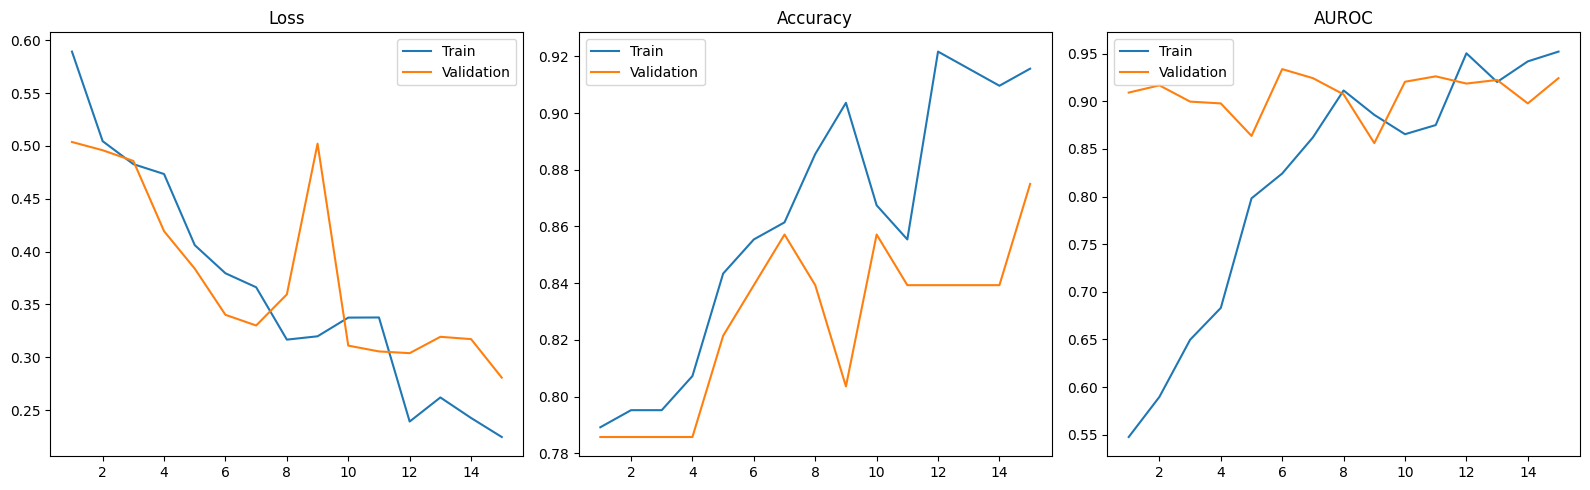

In [ ]:
if __name__ == "__main__":
    labels_dict, metadata_dict, all_patients = load_labels(csv_path, base_path)

    patients = np.array(all_patients)
    labels = np.array([labels_dict[p] for p in patients])

    y_train = np.array([labels_dict[p] for p in train_patients])
    train_patients, val_patients = train_test_split(
        train_patients, test_size=0.25, stratify=y_train, random_state=42
    )

    print(f"Train {len(train_patients)}, Val {len(val_patients)}, Test {len(test_patients)}")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)

    train_dataset = MRIDataset_IDH(base_path, train_patients, labels_dict, metadata_dict)
    val_dataset = MRIDataset_IDH(base_path, val_patients, labels_dict, metadata_dict)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

    idh_model = CNN2D_Meta(n_channels=4, n_meta=2, n_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(idh_model.parameters(), lr=0.001)

    save_path = "/content/drive/MyDrive/IDH_classifier.pth"
    train_model(idh_model, train_loader, val_loader, criterion, optimizer, device, epochs=15)

##Evaluate the model on the test set

In [ ]:
model = CNN2D_Meta(n_channels=4, n_meta=2, n_classes=2).to(device)
model.load_state_dict(torch.load("/content/drive/My Drive/IDH_classifier.pth", map_location=device))
model.eval()

test_dataset = MRIDataset_IDH(base_path, test_patients, labels_dict, metadata_dict)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

n_classes = 2
class_correct = np.zeros(n_classes)
class_total = np.zeros(n_classes)

y_true = []
y_pred_labels = []
y_pred_probs = []

with torch.no_grad():
    for imgs, metas, labels in test_loader:
        imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
        outputs = model(imgs, metas)
        probs = torch.softmax(outputs, dim=1)  # keep all classes
        preds = outputs.argmax(1)

        # Collect results
        y_true.extend(labels.cpu().numpy())
        y_pred_labels.extend(preds.cpu().numpy())
        y_pred_probs.extend(probs.cpu().numpy())

        # Per-class accuracy
        for c in range(n_classes):
            idx = labels == c
            class_total[c] += idx.sum().item()
            class_correct[c] += (preds[idx] == labels[idx]).sum().item()

y_pred_probs = np.array(y_pred_probs)  # shape: [num_samples, n_classes]


Below we include some performance metrics of the IDH model. We can see that the classifier performs better on the IDH wildtype gliomas while only identifying about 57% IDH mutant type gliomas in the test set correctly.

While the ROC curves look similar for both classes (with identical RUC scores), we can see that the Precision-Recall Curves are very different. The PR curve for the mutant type is visually flatter and more rapidly decreasing as recall increases (ie more true positives). This could be due to imbalance in our dataset and not enough IDH mutant data points.


 Test Accuracy: 84.85%
  Wildtype Accuracy: 92.31%
  Mutant Accuracy: 57.14%

Classification Report:
              precision    recall  f1-score   support

    Wildtype       0.89      0.92      0.91        78
      Mutant       0.67      0.57      0.62        21

    accuracy                           0.85        99
   macro avg       0.78      0.75      0.76        99
weighted avg       0.84      0.85      0.84        99



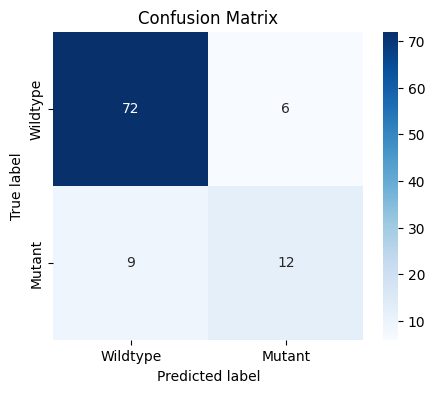

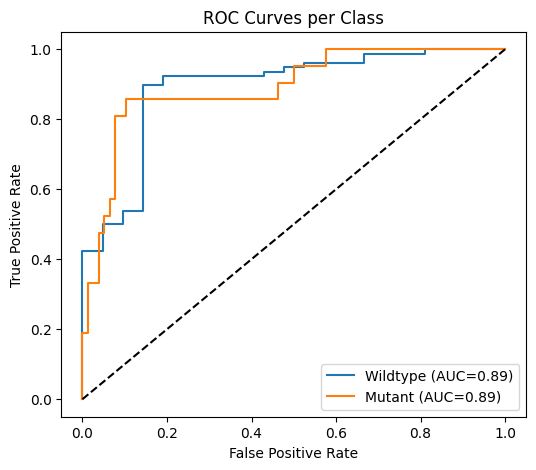

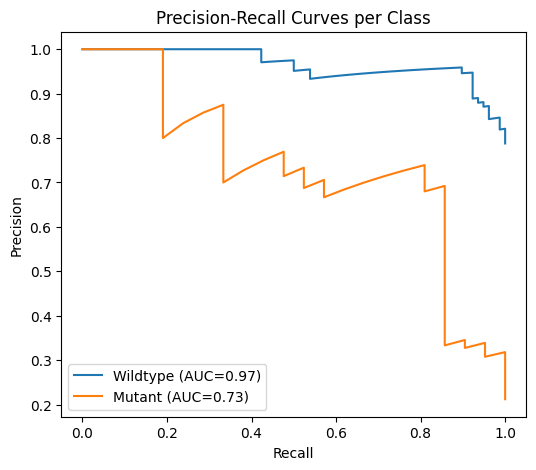

In [ ]:
import torch
import numpy as np
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, precision_recall_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

test_acc = 100 * np.sum(class_correct) / np.sum(class_total)
per_class_acc = 100 * class_correct / np.maximum(class_total, 1)

print(f"\n Test Accuracy: {test_acc:.2f}%")
for c in range(n_classes):
    label_name = "Wildtype" if c == 0 else "Mutant"
    print(f"  {label_name} Accuracy: {per_class_acc[c]:.2f}%")

print("\nClassification Report:")
print(classification_report(y_true, y_pred_labels, target_names=["Wildtype", "Mutant"]))

#confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Wildtype","Mutant"],
            yticklabels=["Wildtype","Mutant"])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix")
plt.show()

#ROC curves
plt.figure(figsize=(6,5))
for c in range(n_classes):
    y_true_binary = np.array([1 if y==c else 0 for y in y_true])
    y_prob_class = y_pred_probs[:, c]
    fpr, tpr, _ = roc_curve(y_true_binary, y_prob_class)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{['Wildtype','Mutant'][c]} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Class")
plt.legend()
plt.show()

#Precision-Recall Curve
plt.figure(figsize=(6,5))
for c in range(n_classes):
    y_true_binary = np.array([1 if y==c else 0 for y in y_true])
    y_prob_class = y_pred_probs[:, c]
    precision, recall, _ = precision_recall_curve(y_true_binary, y_prob_class)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{['Wildtype','Mutant'][c]} (AUC={pr_auc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves per Class")
plt.legend()
plt.show()
